In [121]:
print("Preparing environment...")

from astropy import table as tbl
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import constants as c

%matplotlib widget

print("Done.")

Preparing environment...
Done.


In [183]:
# Function to grab spectra files
def Grab_Spectra(SpecDir, Filename):
    Spectrum_file = fits.open(SpecDir + Filename)
    Spectrum_flux = Spectrum_file[1].data
    Spectrum_wave = Spectrum_file[9].data
    Spectrum = tbl.Table([Spectrum_wave, Spectrum_flux], names=("Wavelength", "Flux"))
    return Spectrum

# Function to grab filter curves
def Grab_Filter(FilDir, Filename):
    Filter = tbl.Table.read(FilDir + Filename, format="ascii")
    Filter["Microns"] = Filter["Microns"] * 10 ** (-6)
    Filter.rename_column("Microns", "Wavelength")
    return Filter

# Function to parse tables and set any rows with NaNs to zero, to avoid errors
def Remove_NaNs(Table_obj):
    for col in Table_obj.colnames:
        for x in range(0, len(Table_obj[col]), 1):
            if np.isnan(Table_obj[col][x]):
                print(f"NaN found! Position {x}")
                Table_obj[col][x] = 0
    return Table_obj

# Function to interpolate datapoints
def Inter_Func(func_x, func_y):
    func_cube = sp.interpolate.interp1d(func_x, func_y, kind='cubic')
    return func_cube

# Function to find grid overlap for convolutions
def Find_Grid(func_x, new_grid, grid_data):
    idx_sorted = np.argsort(new_grid)
    sorted_grid = np.array(new_grid[idx_sorted])
    idx_left = np.searchsorted(sorted_grid, func_x[0], side="right")
    if new_grid[idx_left-1] == func_x[0]:
        idx_left -= 1
    idx_right = np.searchsorted(sorted_grid, func_x[-1], side="left")
    if new_grid[idx_right] != func_x[-1]:
        idx_right -= 1
    func_grid = sorted_grid[idx_left:idx_right]
    grid_overlap = np.array(grid_data[idx_sorted])[idx_left:idx_right]
    return func_grid, grid_overlap

# Function to integrate two functions on the same grid
def Integ_Func(func_conv, grid_overlap, func_grid):
    func_int = np.trapz(func_conv * grid_overlap, x=func_grid)
    return func_int

# Function to normalise the throughput to the correct zero-point
def Norm_Func(func_conv, func_grid, func_int):
    # norm_ref = 10**(48.6/(-2.5)) # reference zero magnitude
    norm_ref = 1 * u.Jy.to(u.W / ((u.m)**2 * u.Hz)) * 10**(-6) # reference flat-value in f_nu
    norm_grid = norm_ref * c.c / func_grid**2 * func_grid # not squared, f_lambda in photon_space
    print(norm_grid)
    norm_val = Integ_Func(func_conv, norm_grid, func_grid)
    func_normed = func_int / norm_val
    return norm_val, func_normed

# Function to manage overall convolution calculation
def Convolve_Func(func_x, func_y, new_grid, grid_data):
    # Interpolate datapoints
    func_inter = Inter_Func(func_x, func_y)
    # Find relevant convolution grid
    func_grid, grid_overlap = Find_Grid(func_x, new_grid, grid_data)
    # Convolve onto grid
    func_conv = func_inter(func_grid)
    # Shift to photon space
    grid_overlap = grid_overlap * func_grid
    # Perform integration
    func_int = Integ_Func(func_conv, grid_overlap, func_grid)
    # Normalise the result
    norm_val, func_normed = Norm_Func(func_conv, func_grid, func_int)
    return norm_val, func_normed, func_int, func_conv, func_grid, grid_overlap

print("Importing data...")
SpecDir = "../../SharedData/NIRSpec/Deep/prism_v1.5/"
Filename = "008115_prism_clear_1D.fits"
Spectrum = Grab_Spectra(SpecDir, Filename)

FilDir = "../../SharedData/NIRSpec/nircam_throughputs/mean_throughputs/"
filelist = !bash -c "ls {FilDir}"

Filter = Grab_Filter(FilDir, filelist[10])

print("Cleaning filters...")
Filter = Remove_NaNs(Filter)
print("Cleaning spectra...")
Spectrum = Remove_NaNs(Spectrum)

print("Interpolating filters...")

Filter_norm, Filter_normed, Filter_through, Filter_conv, Filter_grid, Spectrum_flux = Convolve_Func(Filter["Wavelength"], Filter["Throughput"], Spectrum["Wavelength"], Spectrum["Flux"])

print("Done.")

Importing data...
Cleaning filters...
Cleaning spectra...
NaN found! Position 672
NaN found! Position 673
Interpolating filters...
[1.76984721e-18 1.75734955e-18 1.74504021e-18 1.73291627e-18
 1.72102385e-18 1.70931019e-18 1.69777243e-18 1.68640771e-18
 1.67521321e-18 1.66418611e-18 1.65336948e-18 1.64271391e-18
 1.63221668e-18 1.62187511e-18 1.61168655e-18 1.60164839e-18
 1.59175807e-18 1.58205492e-18 1.57249374e-18 1.56307208e-18
 1.55378752e-18 1.54463767e-18 1.53562018e-18 1.52673274e-18
 1.51797307e-18 1.50933894e-18 1.50082815e-18 1.49243853e-18
 1.48416797e-18 1.47601436e-18 1.46797565e-18 1.46004983e-18
 1.45223492e-18 1.44452897e-18 1.43693006e-18 1.42943633e-18
 1.42204592e-18 1.41475703e-18 1.40756788e-18 1.40047673e-18
 1.39348188e-18 1.38658163e-18 1.37977435e-18 1.37305842e-18
 1.36643226e-18 1.35989430e-18 1.35344303e-18 1.34707695e-18
 1.34079460e-18 1.33459452e-18 1.32847532e-18 1.32240996e-18
 1.31642323e-18 1.31051377e-18]
Done.


In [184]:
46.00287263466458 * 0.000899684595650764 * 0.79917

0.03307610858910542

In [186]:
Filter_normed

0.02476453496627321

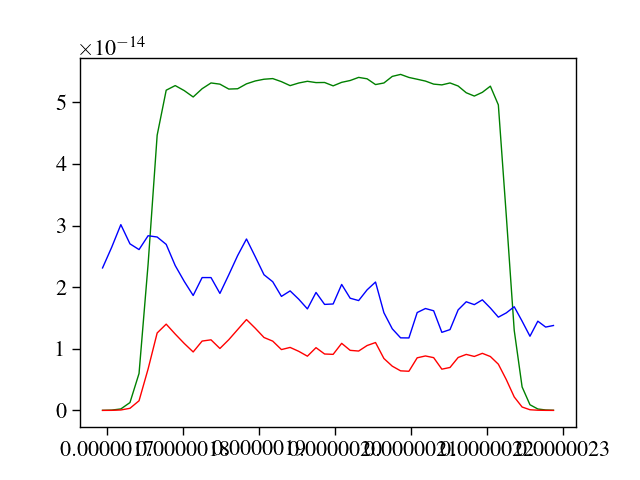

In [156]:
plt.close("all")

# plt.plot(Spectrum["Wavelength"], Spectrum["Flux"])
# plt.plot(Filter["Wavelength"], Filter["Throughput"] * 10 **(-13))
plt.plot(Filter_grid, Filter_conv * 10 **(-13), color='green')
plt.plot(Filter_grid, Spectrum_flux, color='blue')
plt.plot(Filter_grid, Filter_conv * Spectrum_flux, color='red')